In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [23]:
# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
data = pd.read_csv('hour.csv')

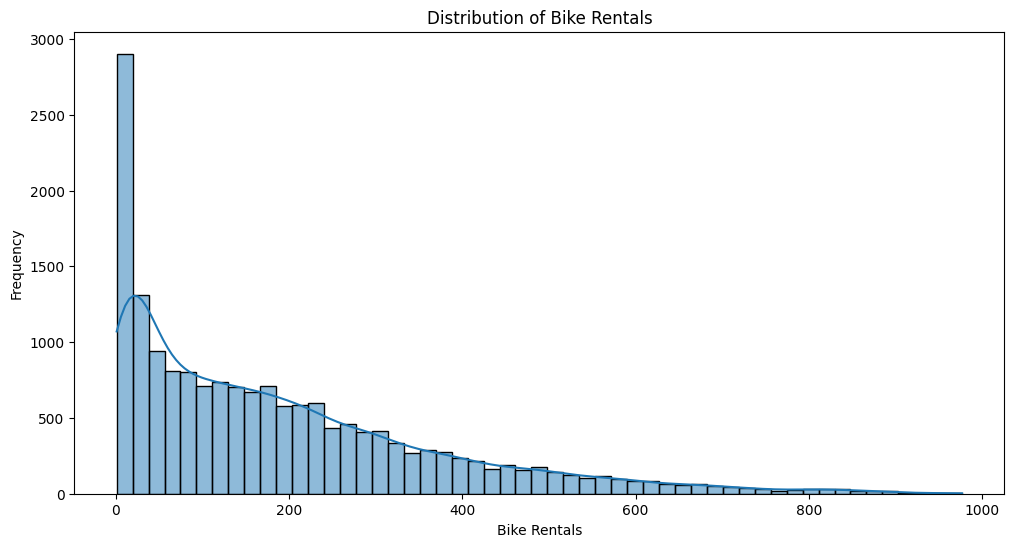

In [24]:
# Visualizations before one-hot encoding
plt.figure(figsize=(12, 6))
sns.histplot(data['cnt'], kde=True)
plt.title('Distribution of Bike Rentals')
plt.xlabel('Bike Rentals')
plt.ylabel('Frequency')
plt.show()

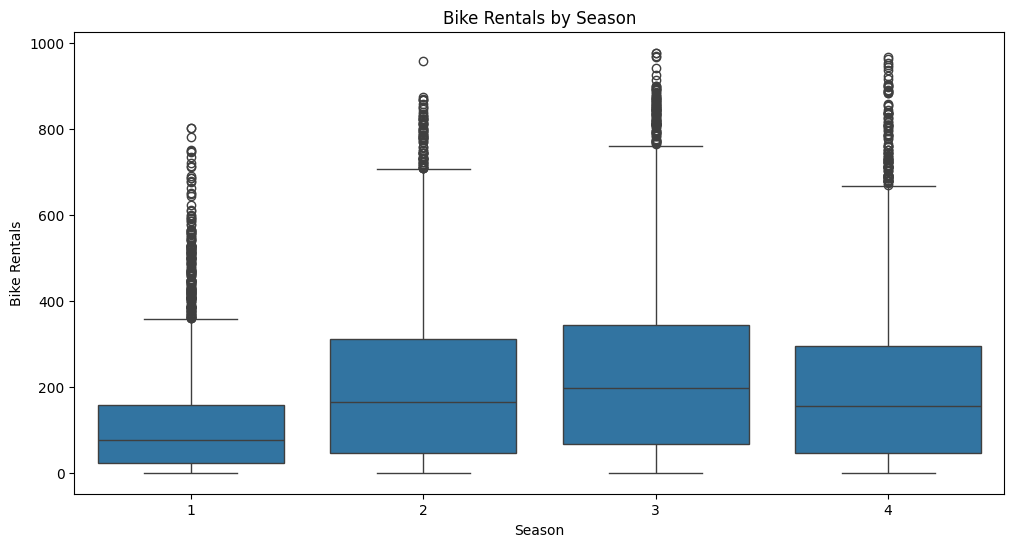

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='season', y='cnt')
plt.title('Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Bike Rentals')
plt.show()

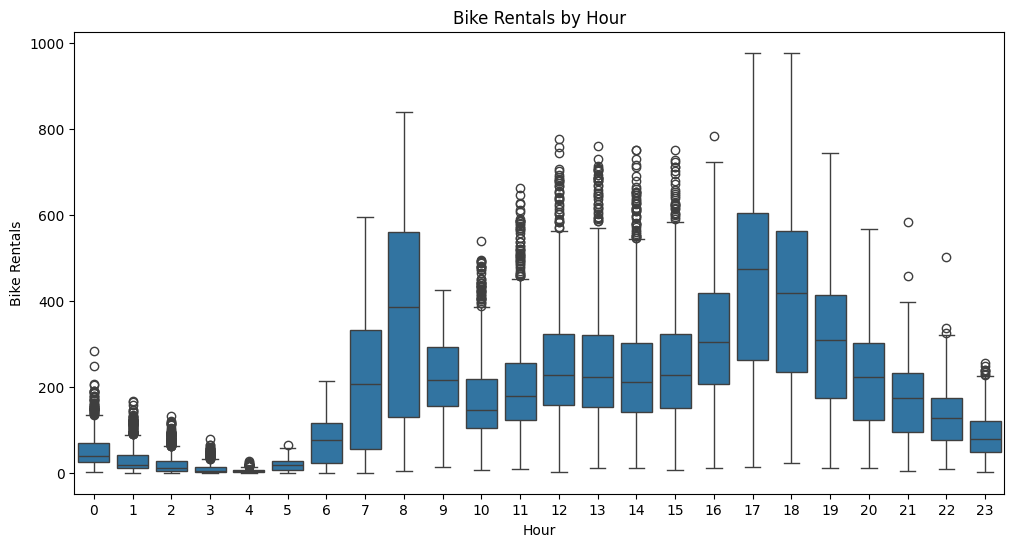

In [26]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='hr', y='cnt')
plt.title('Bike Rentals by Hour')
plt.xlabel('Hour')
plt.ylabel('Bike Rentals')
plt.show()

In [27]:
# Data preprocessing
data = data.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

In [28]:
# One-hot encoding for categorical variables
data = pd.get_dummies(data, columns=['season', 'weathersit', 'mnth', 'hr', 'weekday'])

In [29]:
# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('cnt', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns=data.drop('cnt', axis=1).columns)
scaled_data['cnt'] = data['cnt']

In [30]:
# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [31]:

# Convert to PyTorch tensors
def to_tensor(df):
    inputs = torch.tensor(df.drop('cnt', axis=1).values, dtype=torch.float32)
    targets = torch.tensor(df['cnt'].values, dtype=torch.float32).view(-1, 1)
    return inputs, targets

X_train, y_train = to_tensor(train_data)
X_val, y_val = to_tensor(val_data)
X_test, y_test = to_tensor(test_data)

In [32]:
# Reshape data for RNN/LSTM/GRU [batch_size, seq_length, input_dim]
X_train = X_train.view(X_train.size(0), 1, X_train.size(1))
X_val = X_val.view(X_val.size(0), 1, X_val.size(1))
X_test = X_test.view(X_test.size(0), 1, X_test.size(1))

In [33]:
# Define the RNN model
class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(RNNNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [34]:
# Define the LSTM model
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [40]:
# Define the GRU model
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [41]:
# Hyperparameters
input_dim = X_train.size(2)
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.MSELoss()

In [42]:
# Hyperparameter tuning function
def train_model(model_class, hidden_dim, num_layers, learning_rate, dropout):
    model = model_class(input_dim, hidden_dim, num_layers, dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        val_outputs = model(X_val.to(device))
        val_loss = criterion(val_outputs, y_val.to(device))
        val_losses.append(val_loss.item())

        scheduler.step(val_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return model, train_losses, val_losses

In [43]:
def search_model(params, model_class):
    best_score = float('inf')
    best_params = None
    for hidden_dim in params['hidden_dim']:
        for num_layers in params['num_layers']:
            for lr in params['learning_rate']:
                for dropout in params['dropout']:
                    print(f"Trying params: hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, dropout={dropout}")
                    _, _, val_losses = train_model(model_class, hidden_dim, num_layers, lr, dropout)
                    if val_losses[-1] < best_score:
                        best_score = val_losses[-1]
                        best_params = {'hidden_dim': hidden_dim, 'num_layers': num_layers, 'learning_rate': lr, 'dropout': dropout}
                        print(f"New best score: {best_score} with params: {best_params}")

    return best_params

In [44]:
# Parameters for hyperparameter tuning
param_dist = {
    'hidden_dim': [32, 64, 128, 256],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.001, 0.0001],
    'dropout': [0.1, 0.2, 0.3]
}

# Tuning RNN Model
print("Tuning RNN Model")
best_params_rnn = search_model(param_dist, RNNNet)
print(f'Best Parameters for RNN: {best_params_rnn}')

# Tuning LSTM Model
print("Tuning LSTM Model")
best_params_lstm = search_model(param_dist, LSTMNet)
print(f'Best Parameters for LSTM: {best_params_lstm}')

# Tuning GRU Model
print("Tuning GRU Model")
best_params_gru = search_model(param_dist, GRUNet)
print(f'Best Parameters for GRU: {best_params_gru}')


Tuning RNN Model
Trying params: hidden_dim=32, num_layers=1, lr=0.01, dropout=0.1
Epoch [10/100], Train Loss: 68847.0703, Val Loss: 68593.4453
Epoch [20/100], Train Loss: 67653.5469, Val Loss: 67379.7422
Epoch [30/100], Train Loss: 66255.1484, Val Loss: 65944.4844


c:\Users\abhis\Downloads\Documents\Bike Sharing ANN\ann\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [40/100], Train Loss: 64733.4961, Val Loss: 64391.3086
Epoch [50/100], Train Loss: 63224.7773, Val Loss: 62867.1719
Epoch [60/100], Train Loss: 61793.3008, Val Loss: 61428.5391
Epoch [70/100], Train Loss: 60432.9180, Val Loss: 60063.9648
Epoch [80/100], Train Loss: 59135.0000, Val Loss: 58761.6992
Epoch [90/100], Train Loss: 57897.0977, Val Loss: 57519.3281
Epoch [100/100], Train Loss: 56714.5664, Val Loss: 56332.4805
New best score: 56332.48046875 with params: {'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'dropout': 0.1}
Trying params: hidden_dim=32, num_layers=1, lr=0.01, dropout=0.2
Epoch [10/100], Train Loss: 68831.5312, Val Loss: 68584.8516


c:\Users\abhis\Downloads\Documents\Bike Sharing ANN\ann\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [20/100], Train Loss: 67678.4688, Val Loss: 67409.6406
Epoch [30/100], Train Loss: 66301.3203, Val Loss: 65995.8125
Epoch [40/100], Train Loss: 64821.9922, Val Loss: 64488.2617
Epoch [50/100], Train Loss: 63334.6914, Val Loss: 62981.5234
Epoch [60/100], Train Loss: 61916.2578, Val Loss: 61555.2109
Epoch [70/100], Train Loss: 60566.8164, Val Loss: 60200.8555
Epoch [80/100], Train Loss: 59278.9961, Val Loss: 58907.7305
Epoch [90/100], Train Loss: 58044.0742, Val Loss: 57667.0938
Epoch [100/100], Train Loss: 56862.4805, Val Loss: 56480.7305
Trying params: hidden_dim=32, num_layers=1, lr=0.01, dropout=0.3
Epoch [10/100], Train Loss: 68539.7031, Val Loss: 68280.1953
Epoch [20/100], Train Loss: 67289.9688, Val Loss: 67015.6094


c:\Users\abhis\Downloads\Documents\Bike Sharing ANN\ann\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [30/100], Train Loss: 65875.0391, Val Loss: 65560.0000
Epoch [40/100], Train Loss: 64357.1953, Val Loss: 64010.8633
Epoch [50/100], Train Loss: 62881.8867, Val Loss: 62525.1797
Epoch [60/100], Train Loss: 61481.9883, Val Loss: 61121.1172
Epoch [70/100], Train Loss: 60136.5664, Val Loss: 59773.0430
Epoch [80/100], Train Loss: 58849.9375, Val Loss: 58484.2734
Epoch [90/100], Train Loss: 57623.3438, Val Loss: 57254.3750
Epoch [100/100], Train Loss: 56446.2344, Val Loss: 56072.3672
New best score: 56072.3671875 with params: {'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.01, 'dropout': 0.3}
Trying params: hidden_dim=32, num_layers=1, lr=0.001, dropout=0.1
Epoch [10/100], Train Loss: 69489.2500, Val Loss: 69332.6797
Epoch [20/100], Train Loss: 69415.1562, Val Loss: 69258.2266
Epoch [30/100], Train Loss: 69335.3594, Val Loss: 69177.6016
Epoch [40/100], Train Loss: 69245.1562, Val Loss: 69086.2734
Epoch [50/100], Train Loss: 69141.7734, Val Loss: 68981.8359
Epoch [60/100], Train 

In [45]:
# Retrain the models with the best parameters
def retrain_best_model(model_class, best_params):
    best_hidden_dim = best_params['hidden_dim']
    best_num_layers = best_params['num_layers']
    best_lr = best_params['learning_rate']
    best_dropout = best_params['dropout']

    model = model_class(input_dim, best_hidden_dim, best_num_layers, best_dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=best_lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        val_outputs = model(X_val.to(device))
        val_loss = criterion(val_outputs, y_val.to(device))
        val_losses.append(val_loss.item())

        scheduler.step(val_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return model, train_losses, val_losses

In [46]:
# Retrain the best models
print("Retraining best RNN model")
best_rnn_model, rnn_train_losses, rnn_val_losses = retrain_best_model(RNNNet, best_params_rnn)

print("Retraining best LSTM model")
best_lstm_model, lstm_train_losses, lstm_val_losses = retrain_best_model(LSTMNet, best_params_lstm)

print("Retraining best GRU model")
best_gru_model, gru_train_losses, gru_val_losses = retrain_best_model(GRUNet, best_params_gru)

Retraining best RNN model
Epoch [10/100], Train Loss: 65007.6562, Val Loss: 64180.5000
Epoch [20/100], Train Loss: 57163.1562, Val Loss: 56160.4141
Epoch [30/100], Train Loss: 48955.7031, Val Loss: 47835.1367
Epoch [40/100], Train Loss: 41478.4961, Val Loss: 40387.7695
Epoch [50/100], Train Loss: 34715.9648, Val Loss: 33663.4805
Epoch [60/100], Train Loss: 29157.6738, Val Loss: 28284.6738
Epoch [70/100], Train Loss: 25178.2090, Val Loss: 24463.9590
Epoch [80/100], Train Loss: 22019.0273, Val Loss: 21431.4180
Epoch [90/100], Train Loss: 19475.5996, Val Loss: 18988.7266
Epoch [100/100], Train Loss: 17395.1680, Val Loss: 16992.8320
Retraining best LSTM model
Epoch [10/100], Train Loss: 67423.3828, Val Loss: 66842.7812
Epoch [20/100], Train Loss: 61861.5664, Val Loss: 61082.2422
Epoch [30/100], Train Loss: 55008.5703, Val Loss: 54198.4609
Epoch [40/100], Train Loss: 48015.2070, Val Loss: 47218.6562
Epoch [50/100], Train Loss: 41412.2734, Val Loss: 40627.1719
Epoch [60/100], Train Loss: 355

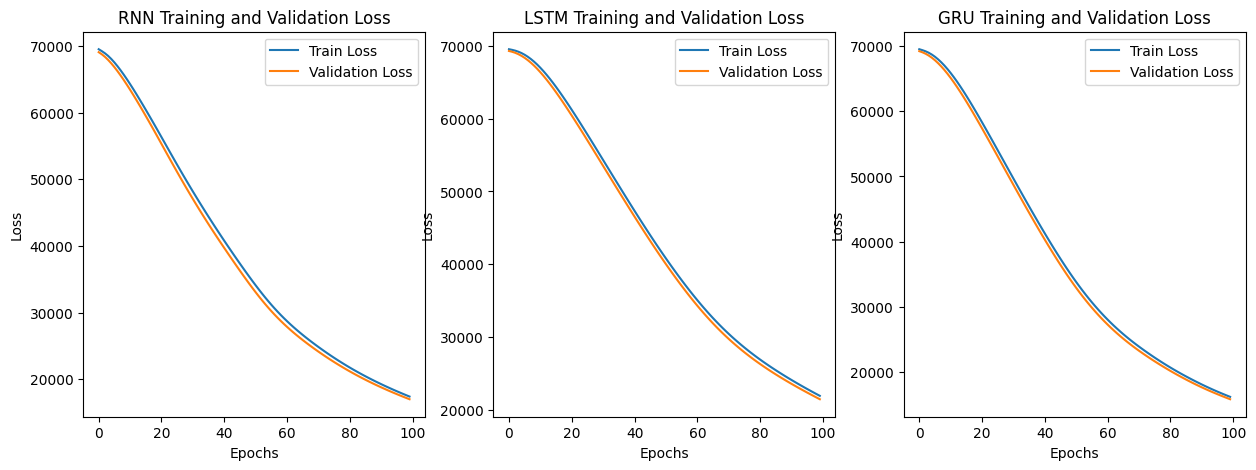

In [65]:
# Plotting training and validation loss for each model
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rnn_train_losses, label='Train Loss')
plt.plot(rnn_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(lstm_train_losses, label='Train Loss')
plt.plot(lstm_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(gru_train_losses, label='Train Loss')
plt.plot(gru_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Training and Validation Loss')

plt.show()

In [78]:
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the MAE and RMSE calculation
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test.to(device))
        test_loss = criterion(test_outputs, y_test.to(device))
        
        # Convert outputs and targets to lists and then to numpy arrays
        test_outputs_list = test_outputs.cpu().detach().tolist()
        y_test_list = y_test.cpu().detach().tolist()
        
        # Convert lists to numpy arrays
        test_outputs_np = np.array(test_outputs_list)
        y_test_np = np.array(y_test_list)
        
        # Calculate MAE and RMSE
        mae = mean_absolute_error(y_test_np, test_outputs_np)
        rmse = mean_squared_error(y_test_np, test_outputs_np, squared=False)
        
        # Calculate R-squared
        total_variance = ((y_test_np - y_test_np.mean())**2).sum()
        explained_variance = ((test_outputs_np - y_test_np.mean())**2).sum()
        r2_score = 1 - (explained_variance / total_variance)
    
    return test_loss.item(), mae, rmse, r2_score.item()

# Evaluate all models
rnn_test_loss, rnn_mae, rnn_rmse, rnn_r2 = evaluate_model(best_rnn_model, X_test, y_test)
lstm_test_loss, lstm_mae, lstm_rmse, lstm_r2 = evaluate_model(best_lstm_model, X_test, y_test)
gru_test_loss, gru_mae, gru_rmse, gru_r2 = evaluate_model(best_gru_model, X_test, y_test)

print(f'RNN Test Loss: {rnn_test_loss:.4f}, MAE: {rnn_mae:.4f}, RMSE: {rnn_rmse:.4f}, R-squared: {rnn_r2:.4f}')
print(f'LSTM Test Loss: {lstm_test_loss:.4f}, MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, R-squared: {lstm_r2:.4f}')
print(f'GRU Test Loss: {gru_test_loss:.4f}, MAE: {gru_mae:.4f}, RMSE: {gru_rmse:.4f}, R-squared: {gru_r2:.4f}')


RNN Test Loss: 16094.8994, MAE: 70.8875, RMSE: 126.8657, R-squared: 0.6819
LSTM Test Loss: 20302.3203, MAE: 81.7619, RMSE: 142.4862, R-squared: 0.6489
GRU Test Loss: 14917.9980, MAE: 65.8543, RMSE: 122.1393, R-squared: 0.6256


c:\Users\abhis\Downloads\Documents\Bike Sharing ANN\ann\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\abhis\Downloads\Documents\Bike Sharing ANN\ann\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\abhis\Downloads\Documents\Bike Sharing ANN\ann\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
